## Contents

1. [Preprocessing Tweets](#preprocessing-tweets)

In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tag import pos_tag
from nltk.corpus import wordnet
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('punkt');

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelromanski/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing Tweets

In [2]:
df = pd.read_csv("data/tweets.csv", encoding='ISO-8859-1')

df.columns = ["unprocessed_tweet", "product", "emotion"]

df.head(3)

,unprocessed_tweet,product,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [3]:
text = df["unprocessed_tweet"]
text

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [4]:
from nltk.corpus import stopwords

stop_words = stopwords.words("english")
stop_words = [i.replace("'", '') for i in stop_words]

stop_words[-5:]
top_words = ['sxsw', 'mention', 'link', 'rt']
stop_words = stop_words + top_words

In [5]:
ex = "[^a-zA-Z\s]"

text = text.str.replace(ex, "", regex=True)
text = text.str.lower()
text

0       wesley i have a g iphone after  hrs tweeting a...
1       jessedee know about fludapp  awesome ipadiphon...
2       swonderlin can not wait for ipad  also they sh...
3       sxsw i hope this years festival isnt as crashy...
4       sxtxstate great stuff on fri sxsw marissa maye...
                              ...                        
9088                            ipad everywhere sxsw link
9089    wave buzz rt mention we interrupt your regular...
9090    googles zeiger a physician never reported pote...
9091    some verizon iphone customers complained their...
9092    rt mention google tests checkin offers at sxsw...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [6]:
from nltk.tokenize import word_tokenize

tokenized_text = text.apply(lambda t: word_tokenize(str(t)))
tokenized_text

0       [wesley, i, have, a, g, iphone, after, hrs, tw...
1       [jessedee, know, about, fludapp, awesome, ipad...
2       [swonderlin, can, not, wait, for, ipad, also, ...
3       [sxsw, i, hope, this, years, festival, isnt, a...
4       [sxtxstate, great, stuff, on, fri, sxsw, maris...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, we, interrupt, your,...
9090    [googles, zeiger, a, physician, never, reporte...
9091    [some, verizon, iphone, customers, complained,...
9092    [rt, mention, google, tests, checkin, offers, ...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [7]:
filtered_text = tokenized_text.apply(lambda x: [word for word in x if word not in stop_words])
filtered_text = filtered_text.apply(lambda x: [word for word in x if len(word) > 1])
filtered_text

0       [wesley, iphone, hrs, tweeting, riseaustin, de...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, years, festival, crashy, years, iphone,...
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [googles, zeiger, physician, never, reported, ...
9091    [verizon, iphone, customers, complained, time,...
9092                     [google, tests, checkin, offers]
Name: unprocessed_tweet, Length: 9093, dtype: object

In [8]:
tagged_text = filtered_text.apply(lambda x: pos_tag(x))
tagged_text

0       [(wesley, NN), (iphone, NN), (hrs, NN), (tweet...
1       [(jessedee, NN), (know, VBP), (fludapp, VBZ), ...
2       [(swonderlin, NN), (wait, NN), (ipad, NN), (al...
3       [(hope, NN), (years, NNS), (festival, JJ), (cr...
4       [(sxtxstate, NN), (great, JJ), (stuff, NN), (f...
                              ...                        
9088                       [(ipad, NN), (everywhere, RB)]
9089    [(wave, NN), (buzz, NN), (interrupt, VBP), (re...
9090    [(googles, NNS), (zeiger, RBR), (physician, JJ...
9091    [(verizon, NN), (iphone, NN), (customers, NNS)...
9092    [(google, NN), (tests, NNS), (checkin, VBP), (...
Name: unprocessed_tweet, Length: 9093, dtype: object

In [9]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatized_text = tagged_text.apply(
    lambda x: [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in x]
)

lemmatized_str = lemmatized_text.apply(lambda x: ' '.join(x))

lemmatized_str

0       wesley iphone hr tweet riseaustin dead need up...
1       jessedee know fludapp awesome ipadiphone app l...
2                          swonderlin wait ipad also sale
3               hope year festival crashy year iphone app
4       sxtxstate great stuff fri marissa mayer google...
                              ...                        
9088                                      ipad everywhere
9089    wave buzz interrupt regularly schedule geek pr...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
9092                            google test checkin offer
Name: unprocessed_tweet, Length: 9093, dtype: object

In [10]:
lemmatized_text

0       [wesley, iphone, hr, tweet, riseaustin, dead, ...
1       [jessedee, know, fludapp, awesome, ipadiphone,...
2                    [swonderlin, wait, ipad, also, sale]
3       [hope, year, festival, crashy, year, iphone, app]
4       [sxtxstate, great, stuff, fri, marissa, mayer,...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, schedule, g...
9090    [google, zeiger, physician, never, report, pot...
9091    [verizon, iphone, customer, complain, time, fe...
9092                       [google, test, checkin, offer]
Name: unprocessed_tweet, Length: 9093, dtype: object

In [11]:
df["processed_tweet"] = lemmatized_str
df.head()

,unprocessed_tweet,product,emotion,processed_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...


In [12]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [13]:
df.to_csv("data/processed_tweets.csv")

In [14]:
df_binary = df.copy()
df_binary = df_binary[df_binary["emotion"].isin(["Negative emotion", "Positive emotion"])]

df_binary["emotion_encoded"] = df_binary["emotion"].replace("Negative emotion", 0).replace("Positive emotion", 1)
df_binary.to_csv("data/processed_tweets_binary.csv")

In [15]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...,1
...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back iphone great cover...,1
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol lavelle,1
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always use camera iphone bc image stabiliz...,1


In [16]:
df_binary['emotion_encoded'].value_counts()

1    2978
0     570
Name: emotion_encoded, dtype: int64

In [17]:
X = df_binary['processed_tweet']
y = df_binary['emotion_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [18]:
bin_forest_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [19]:
bin_forest_pipe.fit(X_train, y_train)

y_pred_forest = bin_forest_pipe.predict(X_test)
forest_test_acc = accuracy_score(y_test, y_pred_forest)
forest_test_acc

0.8577464788732394

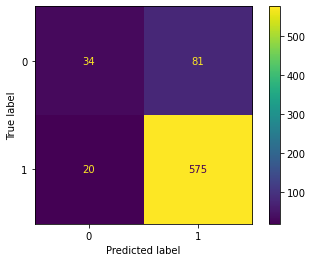

In [20]:
cfm_forest = confusion_matrix(y_test, y_pred_forest)
ConfusionMatrixDisplay(cfm_forest).plot()

In [21]:
y_test

685     1
6393    1
7851    0
5813    0
2944    1
       ..
2707    1
2770    1
6653    1
2127    1
5565    0
Name: emotion_encoded, Length: 710, dtype: int64

In [22]:
forest_score = cross_val_score(bin_forest_pipe, X_train, y_train, cv=5)
forest_score

array([0.85211268, 0.84859155, 0.8556338 , 0.86419753, 0.85361552])

In [22]:
bin_forest_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer(stop_words=stop_words)),
    ('rf', RandomForestClassifier(random_state=42))
    
])

In [23]:
forest_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (1,2), (1,3)],
    'rf__n_estimators': [86, 88, 90],
    'rf__min_samples_split': [10, 20, 30],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
    
}

In [24]:
forest_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (2,2), (3,3)],
    'rf__n_estimators': [86, 88, 90],
    'rf__min_samples_split': [10, 20, 30],
    'rf__class_weight': [None, 'balanced', 'balanced_subsample']
    
}

In [25]:
bin_forest_grid = GridSearchCV(bin_forest_pipe_grid, forest_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
bin_forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...])),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-2,
             param_grid={'rf__class_weight': [None, 'balanced',
                                              'balanced_subsample'],
                         'rf__min_samples_split': [10, 20, 30],
                         'rf__n_estimators': [86, 88, 90],
                         'tf__max_df': [0.88, 0.9, 0.92],
                         'tf__min_df': [0.01, 0.02, 0.03],
                         'tf__ngram_range': [(1, 1), (2, 2), (3, 3)]},
             scoring='accuracy', verbose=1)

In [26]:
print(bin_forest_grid.best_estimator_)
print(bin_forest_grid.best_params_)
print(bin_forest_grid.best_score_)


Pipeline(steps=[('tf',
                 TfidfVectorizer(max_df=0.88, min_df=0.01,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             'youre', 'youve', 'youll', 'youd',
                                             'your', 'yours', 'yourself',
                                             'yourselves', 'he', 'him', 'his',
                                             'himself', 'she', 'shes', 'her',
                                             'hers', 'herself', 'it', 'its',
                                             'its', 'itself', ...])),
                ('rf',
                 RandomForestClassifier(min_samples_split=10, n_estimators=86,
                                        random_state=42))])
{'rf__class_weight': None, 'rf__min_samples_split': 10, 'rf__n_estimators': 86, 'tf__max_df': 0.88, 'tf__min_df': 0.01, 'tf__ngram_range': (

Text(0.5, 1.0, 'Feature importances')

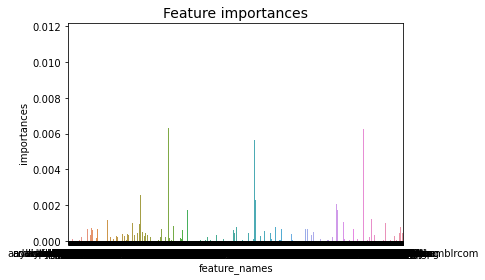

In [35]:
# Extract the TfidfVectorizer from the pipeline
tf_vec = bin_forest_pipe_grid.named_steps['tf']

# Fit the TfidfVectorizer on the training data
tf_vec.fit(X_train)

# Transform the training data using the fitted TfidfVectorizer
X_train_tf = tf_vec.transform(X_train)

# Get the feature names from the TfidfVectorizer
feature_names = tf_vec.get_feature_names_out()

# Extract the RandomForestClassifier from the pipeline
rf = bin_forest_pipe_grid.named_steps['rf']

# Fit the RandomForestClassifier on the transformed training data
rf.fit(X_train_tf, y_train)

# Get the feature importances from the fitted RandomForestClassifier
feature_importances = rf.feature_importances_

# Create a DataFrame with the feature names and their corresponding importances
importances_df = pd.DataFrame({"feature_names": feature_names, "importances": feature_importances})

In [106]:
sorted_importances = importances_df.sort_values(by='importances', ascending=False)
sorted_importances = sorted_importances.head(20)

In [107]:
sorted_importances.to_csv('data/importances.csv')

In [45]:
sentiment = df_binary[['emotion_encoded', 'product']]
sentiment

,emotion_encoded,product
0,0,iPhone
1,1,iPad or iPhone App
2,1,iPad
3,0,iPad or iPhone App
4,1,Google
...,...,...
9077,1,iPhone
9079,1,iPad
9080,0,Other Google product or service
9085,1,iPad or iPhone App


In [51]:
sentiment[sentiment['emotion_encoded'] == 1].value_counts()

emotion_encoded  product                        
1                iPad                               793
                 Apple                              543
                 iPad or iPhone App                 397
                 Google                             346
                 Other Google product or service    236
                 iPhone                             184
                 Android App                         72
                 Android                             69
                 Other Apple product or service      32
dtype: int64

In [122]:
apple_prod = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
mask = sentiment[sentiment['product'].isin(apple_prod)]
mask['emotion_encoded'].value_counts()

1    1949
0     388
Name: emotion_encoded, dtype: int64

In [123]:
tot_apple_review = len(mask)
pos_apple_review = 1949/len(mask)
neg_apple_review = 1 - pos_apple_review
print(pos_apple_review, neg_apple_review)

0.8339751818570817 0.16602481814291825


In [126]:
review_data = {"Positive Review Percentage": [pos_apple_review, pos_google_review],
               "Negative Review Percentage": [neg_apple_review, neg_google_review]
              }
review_df = pd.DataFrame(review_data)
review_df['Brand'] = ['Apple', 'Google']
review_df.to_csv('data/review.csv')

In [59]:
google_prod = ['Google', 'Other Google product or service', 'Android App', 'Android']
g_mask = sentiment[sentiment['product'].isin(google_prod)]
g_mask['emotion_encoded'].value_counts()

1    723
0    131
Name: emotion_encoded, dtype: int64

In [63]:
tot_google_review = len(g_mask)
pos_google_review = 723/tot_google_review
neg_google_review = 1 - pos_google_review
print(pos_google_review, neg_google_review)


0.8466042154566745 0.15339578454332548


In [50]:
tot_apple_products=sentiment.loc[sentiment['product'] == ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 
                                                          'Other Apple product or service']]

ValueError: ('Lengths must match to compare', (3548,), (5,))

In [33]:
for feature, importance in zip(df_binary.processed_tweet, importances):
    print(f"{feature}: {importance:.2f}")

wesley iphone hr tweet riseaustin dead need upgrade plugin station: 0.01
jessedee know fludapp awesome ipadiphone app likely appreciate design also theyre give free t: 0.00
swonderlin wait ipad also sale: 0.01
hope year festival crashy year iphone app: 0.01
sxtxstate great stuff fri marissa mayer google tim oreilly tech booksconferences amp matt mullenweg wordpress: 0.02
start ctia around corner googleio hop skip jump good time android fan: 0.01
beautifully smart simple idea madebymany thenextweb write hollergram ipad app httpbitlyieavob: 0.00
counting day plus strong canadian dollar mean stock apple gear: 0.01
excited meet samsungmobileus show sprint galaxy still run android fail: 0.01
find amp start impromptu party hurricaneparty httpbitlygvlrin cant wait til android app come: 0.00
foursquare ups game time httpjmpgrnpk still prefer gowalla far best look android app date: 0.01
get ta love google calendar feature top party show case check hamsandwich via ischafer gthttpbitlyaxzwxb: 0.0

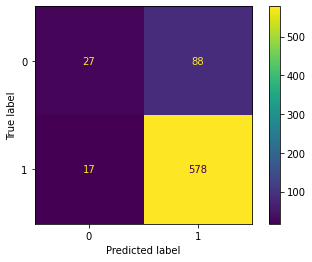

In [58]:
y_pred_forest_grid = bin_forest_grid.predict(X_test)
cfm_forest = confusion_matrix(y_test, y_pred_forest_grid)
ConfusionMatrixDisplay(cfm_forest).plot()

In [59]:

forest_grid_test_acc = accuracy_score(y_test, y_pred_forest_grid)
forest_grid_test_acc 

0.852112676056338

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
486 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
486 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
486 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
567 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
567 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python

array([0.84859155, 0.84507042, 0.84859155, 0.85890653, 0.85185185])

---

In [30]:
bin_log_pipe = Pipeline([
    ('tf', TfidfVectorizer(min_df=.01, max_df=.9, stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

In [31]:
bin_log_pipe.fit(X_train, y_train)

y_pred_log = bin_log_pipe.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log)
log_test_acc

0.8352112676056338

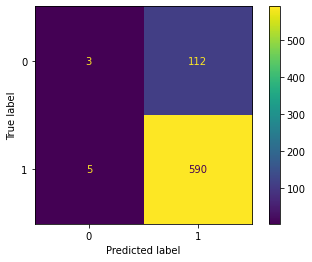

In [32]:
cfm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cfm_log).plot()

In [33]:
log_score = cross_val_score(bin_log_pipe, X_train, y_train, cv=5)
log_score

array([0.83978873, 0.84683099, 0.83978873, 0.84479718, 0.84303351])

In [34]:
bin_log_pipe_grid = Pipeline([
    ('tf', TfidfVectorizer(stop_words=stop_words)),
    ('lr', LogisticRegression(random_state=42))
])

In [ ]:
log_param_grid = {
    'tf__min_df': [.01, .02, .03],
    'tf__max_df': [.88, .90, .92],
    'tf__ngram_range': [(1,1), (2,2), (3,3)],
    'lr__penalty': [None, 'l2', 'l1'],
    'lr__class_weight': [None, 'balanced'],
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__max_iter': [10, 15, 20]
}

In [36]:
bin_log_grid = GridSearchCV(bin_log_pipe_grid, log_param_grid, cv=5, n_jobs=-2, verbose=1, scoring='accuracy')
bin_log_grid.fit(X_train, y_train)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    'youre',
                                                                    'youve',
                                                                    'youll',
                                                                    'youd',
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    'shes',
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it', 'its',
                                                                    'its',
                                                                    'itself', ...])),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-2,
             param_grid={'lr__class_weight': [None, 'balanced'],
                         'lr__max_iter': [10, 15, 20],
                         'lr__penalty': [None, 'l2', 'l1'],
                         'lr__solver': ['lbfgs', 'liblinear'],
                         'tf__max_df': [0.88, 0.9, 0.92],
                         'tf__min_df': [0.01, 0.02, 0.03],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='accuracy', verbose=1)

In [37]:
print(bin_log_grid.best_params_)
print(bin_log_grid.best_score_)

{'lr__class_weight': None, 'lr__max_iter': 10, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'tf__max_df': 0.88, 'tf__min_df': 0.01, 'tf__ngram_range': (1, 1)}
0.8442556574011973


In [38]:
y_pred_log_grid = bin_log_grid.predict(X_test)
log_test_acc = accuracy_score(y_test, y_pred_log_grid)
log_test_acc

0.8408450704225352

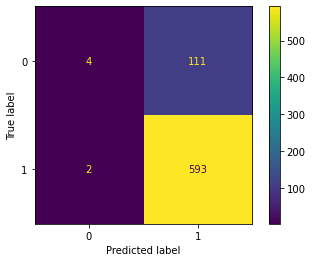

In [39]:
cfm_log = confusion_matrix(y_test, y_pred_log_grid)
ConfusionMatrixDisplay(cfm_log).plot()

In [40]:
log_score = cross_val_score(bin_log_grid, X_train, y_train, cv=5)
log_score

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/michaelromanski/anaconda3/envs/learn-env/lib/pytho

array([0.83978873, 0.83978873, 0.84330986, 0.84479718, 0.84303351])

In [41]:
tf = TfidfVectorizer(min_df = .01, max_df = .9)

X_train_tf = tf.fit_transform(X_train.values)
X_train_tf = X_train_tf.toarray()
X_test_tf = tf.transform(X_test.values)
X_test_tf = X_test_tf.toarray()

In [42]:
nb_model = GaussianNB()

In [43]:
nb_model.fit(X_train_tf, y_train)

y_pred_nb = nb_model.predict(X_test_tf)
nb_test_acc = accuracy_score(y_test, y_pred_nb)
nb_test_acc

0.43661971830985913

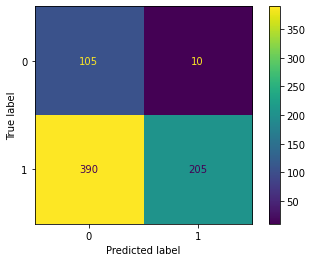

In [44]:
cfm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cfm_nb).plot()

In [45]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.21      0.91      0.34       115
           1       0.95      0.34      0.51       595

    accuracy                           0.44       710
   macro avg       0.58      0.63      0.43       710
weighted avg       0.83      0.44      0.48       710



In [46]:
nb_pipe = Pipeline([
    ('nb', GaussianNB())
])

nb_param_grid = {
    'nb__var_smoothing': [1e-8, 1e-9, 1e-10]
}

In [47]:
nb_grid = GridSearchCV(nb_pipe, nb_param_grid, cv=5, n_jobs=2)
nb_grid.fit(X_train_tf, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('nb', GaussianNB())]), n_jobs=2,
             param_grid={'nb__var_smoothing': [1e-08, 1e-09, 1e-10]})

In [48]:
print(nb_grid.best_params_)
print(nb_grid.best_score_)

{'nb__var_smoothing': 1e-08}
0.43517152296495015


In [49]:
df_binary['list_tokens'] = lemmatized_text

In [50]:
df_binary

,unprocessed_tweet,product,emotion,processed_tweet,emotion_encoded,list_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley iphone hr tweet riseaustin dead need up...,0,"[wesley, iphone, hr, tweet, riseaustin, dead, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know fludapp awesome ipadiphone app l...,1,"[jessedee, know, fludapp, awesome, ipadiphone,..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin wait ipad also sale,1,"[swonderlin, wait, ipad, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year festival crashy year iphone app,0,"[hope, year, festival, crashy, year, iphone, app]"
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff fri marissa mayer google...,1,"[sxtxstate, great, stuff, fri, marissa, mayer,..."
...,...,...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,pr guy convince switch back iphone great cover...,1,"[pr, guy, convince, switch, back, iphone, grea..."
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,quotpapyrussort like ipadquot nice lol lavelle,1,"[quotpapyrussort, like, ipadquot, nice, lol, l..."
9080,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion,diller say google tv quotmight run playstation...,0,"[diller, say, google, tv, quotmight, run, play..."
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,ive always use camera iphone bc image stabiliz...,1,"[ive, always, use, camera, iphone, bc, image, ..."


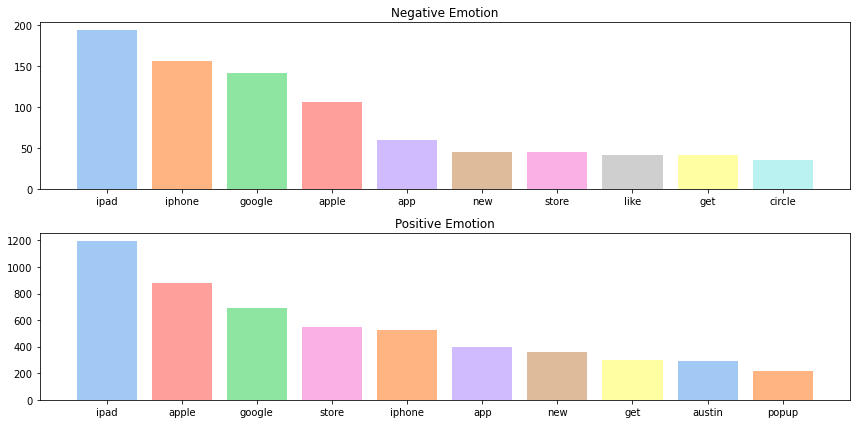

In [51]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))

plotted_words_and_colors = {}

color_palette = sns.color_palette('pastel', n_colors = 38)

data_by_emotion = [y for _, y in df_binary.groupby('emotion_encoded', as_index=False)]
for idx, emotion_df in enumerate(data_by_emotion):
    all_words_in_emotion = emotion_df.list_tokens.explode()
    top_10 = all_words_in_emotion.value_counts()[:10]
    
    colors = []
    for word in top_10.index:
        if word not in plotted_words_and_colors:
             new_color = color_palette.pop(0)
             plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
            
    ax = axes[idx]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(emotion_df.iloc[0].emotion.title())
    
fig.tight_layout()

In [52]:
top_10

ipad      1196
apple      881
google     692
store      549
iphone     522
app        395
new        360
get        301
austin     290
popup      218
Name: list_tokens, dtype: int64

In [64]:
data = pd.read_csv("data/processed_tweets.csv", index_col=0)

data["product"].value_counts()

data_branded = data.copy()

mapping = {
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Google',
    'Other Google product or service': 'Google',
    'Android App': 'Google',
    'Android': 'Google'
}

data_branded["product"] = data_branded["product"].map(mapping)

data_branded.isnull().sum()

data_branded["product"].value_counts()

data_branded[data_branded['product'].isna()]

apple_keywords = ['iPad', 'Apple', 'iPhone']
google_keywords = ['Google', 'Android']

for keyword in apple_keywords:
    mask = (data_branded['product'].isna()) & (data_branded['unprocessed_tweet'].str.contains(keyword, case=False, na=False))
    data_branded.loc[mask, 'product'] = 'Apple'

for keyword in google_keywords:
    mask = (data_branded['product'].isna()) & (data_branded['unprocessed_tweet'].str.contains(keyword, case=False, na=False))
    data_branded.loc[mask, 'product'] = 'Google'

data_branded.isnull().sum()

data_branded.dropna()

data_branded.dropna().to_csv("data/branded.csv")

In [76]:
data_branded['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [77]:
data_branded.isna().sum()

unprocessed_tweet      1
product              762
emotion                0
processed_tweet        2
dtype: int64

In [78]:
data_branded.dropna(inplace=True)

In [79]:
neutral_data = data_branded[data_branded["emotion"] == 'No emotion toward brand or product']

In [80]:
neutral_test = neutral_data['processed_tweet']

In [81]:
neutral_test.dropna(inplace=True)

<ipython-input-81-ccd3b472fde9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neutral_test.dropna(inplace=True)


In [82]:
neutral_test.isna().sum()

0

In [83]:
y_pred_neutral = bin_forest_grid.predict(neutral_test)
y_pred_neutral

array([1, 1, 1, ..., 1, 1, 1])

In [84]:
neutral_test

5       teachntech new ipad apps speechtherapy communi...
16      holler gram ipad itunes app store httptcokfnfq...
32      attn frineds register gdgtlive see cobra irada...
33                              anyone want sell old ipad
34                 anyone buy new ipad want sell old ipad
                              ...                        
9087           yup third app yet im android suggestion cc
9089    wave buzz interrupt regularly schedule geek pr...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
9092                            google test checkin offer
Name: processed_tweet, Length: 4647, dtype: object

In [85]:
neutral_df = neutral_test.to_frame()
neutral_df

,processed_tweet
5,teachntech new ipad apps speechtherapy communi...
16,holler gram ipad itunes app store httptcokfnfq...
32,attn frineds register gdgtlive see cobra irada...
33,anyone want sell old ipad
34,anyone buy new ipad want sell old ipad
...,...
9087,yup third app yet im android suggestion cc
9089,wave buzz interrupt regularly schedule geek pr...
9090,google zeiger physician never report potential...
9091,verizon iphone customer complain time fell bac...


In [87]:
neutral_df['emotion_encoded'] = y_pred_neutral
neutral_df

,processed_tweet,emotion_encoded
5,teachntech new ipad apps speechtherapy communi...,1
16,holler gram ipad itunes app store httptcokfnfq...,1
32,attn frineds register gdgtlive see cobra irada...,1
33,anyone want sell old ipad,1
34,anyone buy new ipad want sell old ipad,1
...,...,...
9087,yup third app yet im android suggestion cc,1
9089,wave buzz interrupt regularly schedule geek pr...,1
9090,google zeiger physician never report potential...,1
9091,verizon iphone customer complain time fell bac...,1


In [88]:
neutral_df['emotion_encoded'].value_counts()

1    4407
0     240
Name: emotion_encoded, dtype: int64

In [89]:
neutral_df[neutral_df['emotion_encoded'] == 0]

,processed_tweet,emotion_encoded
123,funny austin trend matter minute point least a...,0
312,tweet google come circle platform today outsid...,0
330,long line else apple store,0
401,austin classic miss mblogcom twitter iphone pm,0
496,dslr film discussion moderate guy kawasaki app...,0
...,...,...
8937,browser prefer internet explorer google chrome...,0
8953,google bloggersketchup party unexpectedly quie...,0
9014,crazy think upgrade iphone right,0
9016,smoked way much yesterday hahaha austin wakenb...,0


In [69]:
idk_data = data_branded[data_branded['emotion'] == "I can't tell"]
idk_test = idk_data['processed_tweet']

In [90]:
y_pred_idk = bin_forest_grid.predict(idk_test)
y_pred_idk

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1])

In [92]:
idk_df = idk_test.to_frame()
idk_df['emotion_encoded'] = y_pred_idk
idk_df

,processed_tweet,emotion_encoded
90,thanks publish news new medical apps sxswi con...,1
102,quotapple open popup store austin nerd town ge...,1
237,america need google launch major new social ne...,0
341,queue apple store austin four block long crazy...,0
368,hope well wave buzz google preview social netw...,0
...,...,...
9020,funny watching room full people hold ipad air ...,1
9032,yeah google nothing u,1
9037,yes google presentation exactly expect,0
9058,quotdo know apple really good make feel bad xm...,1


In [167]:
idk_df['emotion_encoded'].value_counts()

1    136
0     20
Name: emotion_encoded, dtype: int64

Negative Tweets about apple that are marked positive

In [139]:
df['unprocessed_tweet'][9066]

'How much you want to bet Apple is disproportionately stocking the #SXSW pop-up store with iPad 2? The influencer/hipsters thank you'

In [127]:
df['unprocessed_tweet'][9058]

'&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?'

In [188]:
df['unprocessed_tweet'][102]

'\x89ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow'

In [189]:
df['unprocessed_tweet'][441]

'Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link}'

Negative tweet about Google that was marked positive

In [151]:
df['unprocessed_tweet'][9032]

'@mention yeah, we have @mention , Google has nothing on us :) #SXSW'

Properly labeled negative tweet about apple

In [172]:
df['unprocessed_tweet'][1670]

'Apple is &quot;the classiest, fascist company in America,&quot; says @mention #sxsw'

In [ ]:
df['unprocessed_tweet'][4002]

Positive tweet about Google marked as negative

In [174]:
df['unprocessed_tweet'][3855]

'@mention is biyt.ly for email, like google voice for email #loveit #sxsw #startupbus'

Positive tweet about Apple marked as negative

In [182]:
df['unprocessed_tweet'][4862]

'It is also limited in its abilities. Its a balance. RT @mention @mention An iPad is cheaper than most laptops. #newsapps #sxsw'

Possibly properly labeled negative google tweet

In [191]:
df['unprocessed_tweet'][9037]

'@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw'

properly labeled positive tweet about Apple

In [196]:
df['unprocessed_tweet'][488]

'Gave into extreme temptation at #SXSW and bought an iPad 2... #impulse'

This tweet is interesting, both positive and negative depending on what brand

In [195]:
df['unprocessed_tweet'][705]

'Forgot my iPhone for #sxsw. Android only. Knife to a gun fight'

In [184]:
idk_df[idk_df['emotion_encoded'] == 1].head(60)

,processed_tweet,emotion_encoded
90,thanks publish news new medical apps sxswi con...,1
102,quotapple open popup store austin nerd town ge...,1
413,syd crew iphone extra juice pod procure,1
441,barry diller think ipad content nut,1
488,give extreme temptation buy ipad impulse,1
640,catch mean ipad,1
705,forgot iphone android knife gun fight,1
749,google lanzara ningun producto en south southwest,1
882,comprando mi ipad en el apple store others,1
1069,say google get drunk hckers,1
